In [104]:
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns

df_full_user = pd.read_csv("../preprosscedDataSet.csv")
df_games = pd.read_csv("../full_api_preprocessing.csv")

In [115]:
df_user = pd.DataFrame(df_full_user[["user_id","03_hltb_id"," time_is_play", "06_time_100"]])
df_user.head()

,user_id,03_hltb_id,time_is_play,06_time_100
0,5250,368.0,5.9,54486.0
1,76767,368.0,1.8,54486.0
2,298950,368.0,2.6,54486.0
3,975449,368.0,10.8,54486.0
4,1364546,368.0,1.9,54486.0


Shooter                       189
Strategy                      120
Simulator                      96
Role-playing (RPG)             88
Adventure                      74
Platform                       74
Racing                         51
Music                          46
Real Time Strategy (RTS)       33
Fighting                       30
Sport                          24
Puzzle                         13
Point-and-click                 7
Hack and slash/Beat 'em up      2
Turn-based strategy (TBS)       1
Name: genre1, dtype: int64


<AxesSubplot:ylabel='genre1'>

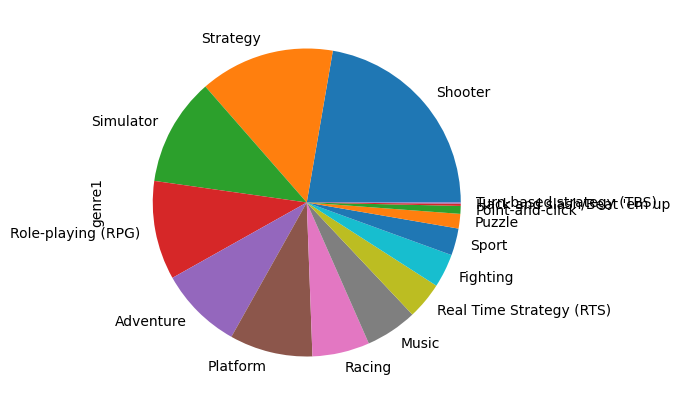

In [186]:
print(pd.merge(df_user[df_user["user_id"]==975449], df_games, left_on="03_hltb_id", right_on="03_hltb_id", how="inner")["genre1"].value_counts())
pd.merge(df_user[df_user["user_id"]==975449], df_games, left_on="03_hltb_id", right_on="03_hltb_id", how="inner")["genre1"].value_counts().plot.pie(figsize=(5, 5))

In [107]:
df_user["rating_reco"] = df_user[" time_is_play"]/df_user["06_time_100"]
df_user["rating_reco"] = df_user["rating_reco"].replace(-np.inf,0)
df_user["rating_reco"] = df_user["rating_reco"].replace(np.inf,0)
df_user.pop(" time_is_play")
df_user.pop("06_time_100")
df_user = df_user.dropna()
df_user.shape
df_user.describe()

,user_id,03_hltb_id,rating_reco
count,9.792400e+04,97924.000000,97924.000000
mean,1.041839e+08,10896.321402,0.000094
std,7.361022e+07,11882.821308,0.000578
min,5.250000e+03,32.000000,0.000000
25%,4.541169e+07,3110.000000,0.000001
50%,8.691201e+07,7980.000000,0.000014
75%,1.565879e+08,15539.000000,0.000057
max,3.099031e+08,109060.000000,0.086613


In [108]:
df_user = df_user[df_user["rating_reco"]<0.000100]
df_user = df_user[df_user["rating_reco"]>0.0000001]
df_user["rating_reco_100"] = (df_user["rating_reco"]*100)/df_user["rating_reco"].max()
df_user.describe()

,user_id,03_hltb_id,rating_reco,rating_reco_100
count,6.416200e+04,64162.000000,6.416200e+04,64162.000000
mean,1.019419e+08,9083.648187,2.204680e-05,22.053221
std,7.339141e+07,9447.332969,2.381643e-05,23.823359
min,5.250000e+03,50.000000,1.019466e-07,0.101976
25%,4.368463e+07,2721.000000,3.843390e-06,3.844509
50%,8.549786e+07,6944.000000,1.355014e-05,13.554080
75%,1.542307e+08,11037.000000,3.247586e-05,32.485312
max,3.099031e+08,109060.000000,9.997089e-05,100.000000


In [109]:
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(0, 100))
data = Dataset.load_from_df(df_user[['user_id', '03_hltb_id', 'rating_reco_100']], reader)

svd = SVD(verbose=True, n_epochs=10)
cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

trainset = data.build_full_trainset()
svd.fit(trainset)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Evaluating RMSE, MAE of algorithm SVD on 5 split(s

In [175]:
import difflib
import random

def get_game_id(game_title, metadata):
    
    existing_titles = list(metadata['01_game_name'].values)
    closest_titles = difflib.get_close_matches(game_title, existing_titles)
    game_id = metadata[metadata['01_game_name'] == closest_titles[0]]['03_hltb_id'].values[0]
    return game_id

def get_game_info(game_id, metadata):
    
    game_info = metadata[metadata['03_hltb_id'] == game_id][['03_hltb_id', '01_game_name', 
                                                    'genre1']]
    return game_info.to_dict(orient='records')

def predict_review(user_id, game_title, model, metadata):
    
    game_id = get_game_id(game_title, metadata)
    review_prediction = model.predict(uid=user_id, iid=game_id)
    return review_prediction.est

def generate_recommendation(user_id, model, metadata, thresh=70):
    
    game_titles = list(metadata['01_game_name'].values)
    random.shuffle(game_titles)

    TEMPS =[]


    for game_title in game_titles:
        rating = predict_review(user_id, game_title, model, metadata)
        TEMPS.append((game_title,rating))
        # if rating >= thresh:
        #     game_id = get_game_id(game_title, metadata)
        #     TEMPS.append(get_game_info(game_id, metadata))
        #     i = i + 1
        #     if i == 3 :
        #         break
    TEMPS.sort(key=lambda y: y[1], reverse=True)
    return TEMPS

        

In [176]:
generate_recommendation(97782908, svd, df_games)

[('Half-Life Blue Shift', 83.58652814327425),
 ('Polarity', 80.90120171419795),
 ('Why So Evil', 79.35533760440441),
 ('Terra Incognita ~ Chapter One The Descendant', 76.02159714942253),
 ("Five Nights at Freddy's", 74.6747619264072),
 ('Age of Chivalry', 73.83700950737648),
 ('Scribblenauts Unlimited', 72.81373696394468),
 ('Defy Gravity', 72.57246124607002),
 ('Hitman Sniper Challenge', 72.51167831052626),
 ('Lugaru HD ', 72.01057677815173),
 ('Chains', 71.60526552942788),
 ('McPixel', 71.40227646495964),
 ('Sinister City', 71.20326373766981),
 ('Absconding Zatwor', 71.18192896424694),
 ('Shadows on the Vatican - Act I Greed', 71.09529676596577),
 ('Frankenstein Master of Death', 71.08141839535452),
 ('Gone Home', 70.86885848395849),
 ('Why So Evil 2 Dystopia', 70.43388644137131),
 ('Thomas Was Alone', 69.99891262373734),
 ('Eets Munchies', 69.06800693222138),
 ('Yet Another Zombie Defense', 68.54251212258487),
 ('Secret Of Magia', 68.42328082059655),
 ('Sigils of Elohim', 67.9441780

In [203]:
generate_recommendation(127555883, svd, df_games)

[('Command and Conquer Red Alert 3', 80.71685909305714),
 ('Half-Life Blue Shift', 68.18589252449596),
 ('Polarity', 67.31132916428632),
 ('Hitman Sniper Challenge', 65.54914361094583),
 ('Sigils of Elohim', 62.59691251205209),
 ('Thomas Was Alone', 58.50860111471936),
 ('Call of Duty Modern Warfare 2', 58.18210929715251),
 ('Castle Crashers', 57.89848762243527),
 ('Gone Home', 57.750504057404996),
 ('VVVVVV', 56.44186088838107),
 ('Why So Evil', 56.38728654014608),
 ('Terra Incognita ~ Chapter One The Descendant', 55.4080276189901),
 ('Lugaru HD ', 54.233656452871486),
 ('Absconding Zatwor', 54.060155087238954),
 ('McPixel', 53.89018347722025),
 ('Defy Gravity', 53.844429271861856),
 ('Shadows on the Vatican - Act I Greed', 53.13801749588376),
 ('Tales of Monkey Island Chapter 2 - The Siege of Spinner Cay ',
  52.56186146334302),
 ('PAC-MAN Championship Edition DX+', 52.26808384220563),
 ('Eets Munchies', 51.88561014188733),
 ('Machinarium', 51.470188521315805),
 ('The Stanley Parable

In [185]:
df_games[df_games["01_game_name"]=="McPixel"]["genre1"]

2220    Point-and-click
Name: genre1, dtype: object

In [194]:
df_full_user.groupby(["user_id","genre1"]).count()

Unnamed: 0  game_name   time_is_play  \
user_id   genre1                                                           
5250      Shooter                           11         11             11   
          Strategy                           1          1              1   
76767     Adventure                          1          1              1   
          Real Time Strategy (RTS)           1          1              1   
          Shooter                           10         10             10   
...                                        ...        ...            ...   
309404240 Simulator                          1          1              1   
309434439 Strategy                           1          1              1   
309812026 Shooter                            1          1              1   
309824202 Strategy                           1          1              1   
309903146 Strategy                           1          1              1   

                                    02_hltb_name  03_hltb_id  04_time_main  \
user_id   genre1                                                             
5250      Shooter                             11          11            11   
          Strategy                             1           1             1   
76767     Adventure                            1           1             1   
          Real Time Strategy (RTS)             1           1             1   
          Shooter                             10          10            10   
...                                          ...         ...           ...   
309404240 Simulator                            1           1             1   
309434439 Strategy                             1           1             1   
309812026 Shooter                              1           1             1   
309824202 Strategy                             1           1             1   
309903146 Strategy                             1           1             1   

                                    05_time_plus  06_time_100  \
user_id   genre1                                                
5250      Shooter                             11           11   
          Strategy                             1            1   
76767     Adventure                            1            1   
          Real Time Strategy (RTS)             1            1   
          Shooter                             10           10   
...                                          ...          ...   
309404240 Simulator                            1            1   
309434439 Strategy                             1            1   
309812026 Shooter                              1            1   
309824202 Strategy                             1            1   
309903146 Strategy                             1            1   

                                    07_time_allstyle  08_count_main  ...  \
user_id   genre1                                                     ...   
5250      Shooter                                 11             11  ...   
          Strategy                                 1              1  ...   
76767     Adventure                                1              1  ...   
          Real Time Strategy (RTS)                 1              1  ...   
          Shooter                                 10             10  ...   
...                                              ...            ...  ...   
309404240 Simulator                                1              1  ...   
309434439 Strategy                                 1              1  ...   
309812026 Shooter                                  1              1  ...   
309824202 Strategy                                 1              1  ...   
309903146 Strategy                                 1              1  ...   

                                    keywords4  keywords5  name  rating  \
user_id   genre1                                                         
5250      Shooter                          11    

In [202]:
df_full_user[df_full_user["user_id"]==127555883]["genre1"].value_counts()

Role-playing (RPG)          5
Puzzle                      2
Real Time Strategy (RTS)    2
Racing                      1
Fighting                    1
Name: genre1, dtype: int64

In [201]:
df_full_user["shooter"] = df_full_user[df_full_user["genre1"]=="Shooter"]["genre1"].value_counts()

Shooter    29844
Name: genre1, dtype: int64